In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
paths = ['1_day_-2', '1_day_-1', '1_day_0',
         '3_day_0',  '3_day_1',  '3_day_2',
         '4_day_1',  '4_day_2',  '4_day_3']

def get_data(path, price_data = False):
    if price_data:
        return pd.read_csv(f'../prices/prices_round_{path}.csv', sep=';', header=0)
    return pd.read_csv(f'../prices/trades_round_5/trades_round_{path}_wn.csv', sep=';', header=0)

get_data(paths[6]).head()

,timestamp,buyer,seller,symbol,currency,price,quantity
0,800,Valentina,Valentina,COCONUT_COUPON,SEASHELLS,636.0,5
1,900,Valentina,Vinnie,COCONUT_COUPON,SEASHELLS,634.0,17
2,1100,Valentina,Ruby,COCONUT_COUPON,SEASHELLS,635.0,17
3,1900,Valentina,Vinnie,COCONUT_COUPON,SEASHELLS,635.0,16
4,2000,Valentina,Vinnie,COCONUT_COUPON,SEASHELLS,637.0,14


In [4]:
def calculate_specific_profits(trades, prices, trader, product):
    last_price = prices[(prices['timestamp'] == prices['timestamp'].max()) & (prices['product'] == product)]['mid_price'].values[0]

    df = trades[(trades['buyer'] == trader) & (trades['symbol'] == product)]
    profit = (df['price'] * df['quantity']).sum()
    position = df['quantity'].sum()
    
    df = trades[(trades['seller'] == trader) & (trades['symbol'] == product)]
    profit -= (df['price'] * df['quantity']).sum()
    position -= df['quantity'].sum()

    return profit - position * last_price

In [5]:
vipers = ['Valentina', 'Vinnie', 'Vladimir', 'Vivian']
cobras = ['Celeste', 'Colin', 'Carlos', 'Camilla']
pythons = ['Pablo', 'Penelope', 'Percy', 'Petunia']
rattlesnakes = ['Ruby', 'Remy', 'Rihanna', 'Raj']
anacondas = ['Amelia', 'Adam', 'Alina', 'Amir']
traders = vipers + cobras + pythons + rattlesnakes + anacondas

products = ['AMETHYSTS', 'STARFRUIT', 'ORCHIDS', 'CHOCOLATE', 'ROSES', 'STRAWBERRIES', 'GIFT_BASKET', 'COCONUT', 'COCONUT_COUPON']

In [6]:
profits = {product: {trader: 0 for trader in traders} for product in products}
for path in paths:
    trades = get_data(path)
    prices = get_data(path, price_data=True)

    unique_traders = pd.concat([trades['buyer'], trades['seller']], axis=0).unique()
    unique_products = trades['symbol'].unique()
    for trader in traders:
        if trader not in unique_traders:
            continue
        for product in products:
            if product not in unique_products:
                continue
            profits[product][trader] += calculate_specific_profits(trades, prices, trader, product)

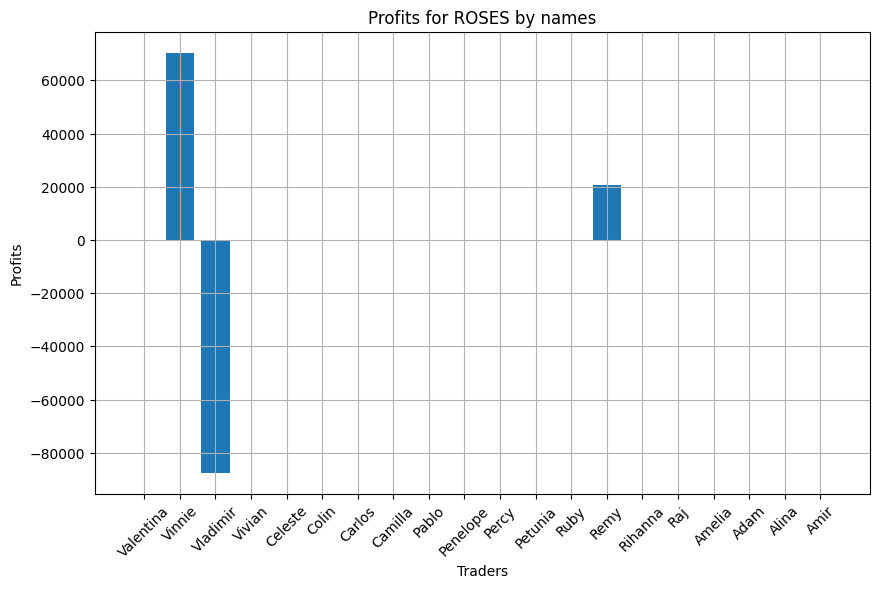

In [48]:
visualizing_product = 'ROSES'

plt.figure(figsize=(10, 6))
plt.bar(traders, list(profits[visualizing_product].values()))
plt.xticks(rotation=45)
plt.grid()
plt.ylabel('Profits')
plt.xlabel('Traders')
plt.title(f'Profits for {visualizing_product} by names')
plt.show()


In [61]:
visualizing_path_index = 5
visualizing_trader = 'Vinnie'

trades = get_data(paths[visualizing_path_index])
trades = trades[trades['symbol'] == visualizing_product]
print(pd.concat([trades['buyer'], trades['seller']], axis=0).unique())

['Remy' 'Vinnie' 'Vladimir' 'Rhianna']


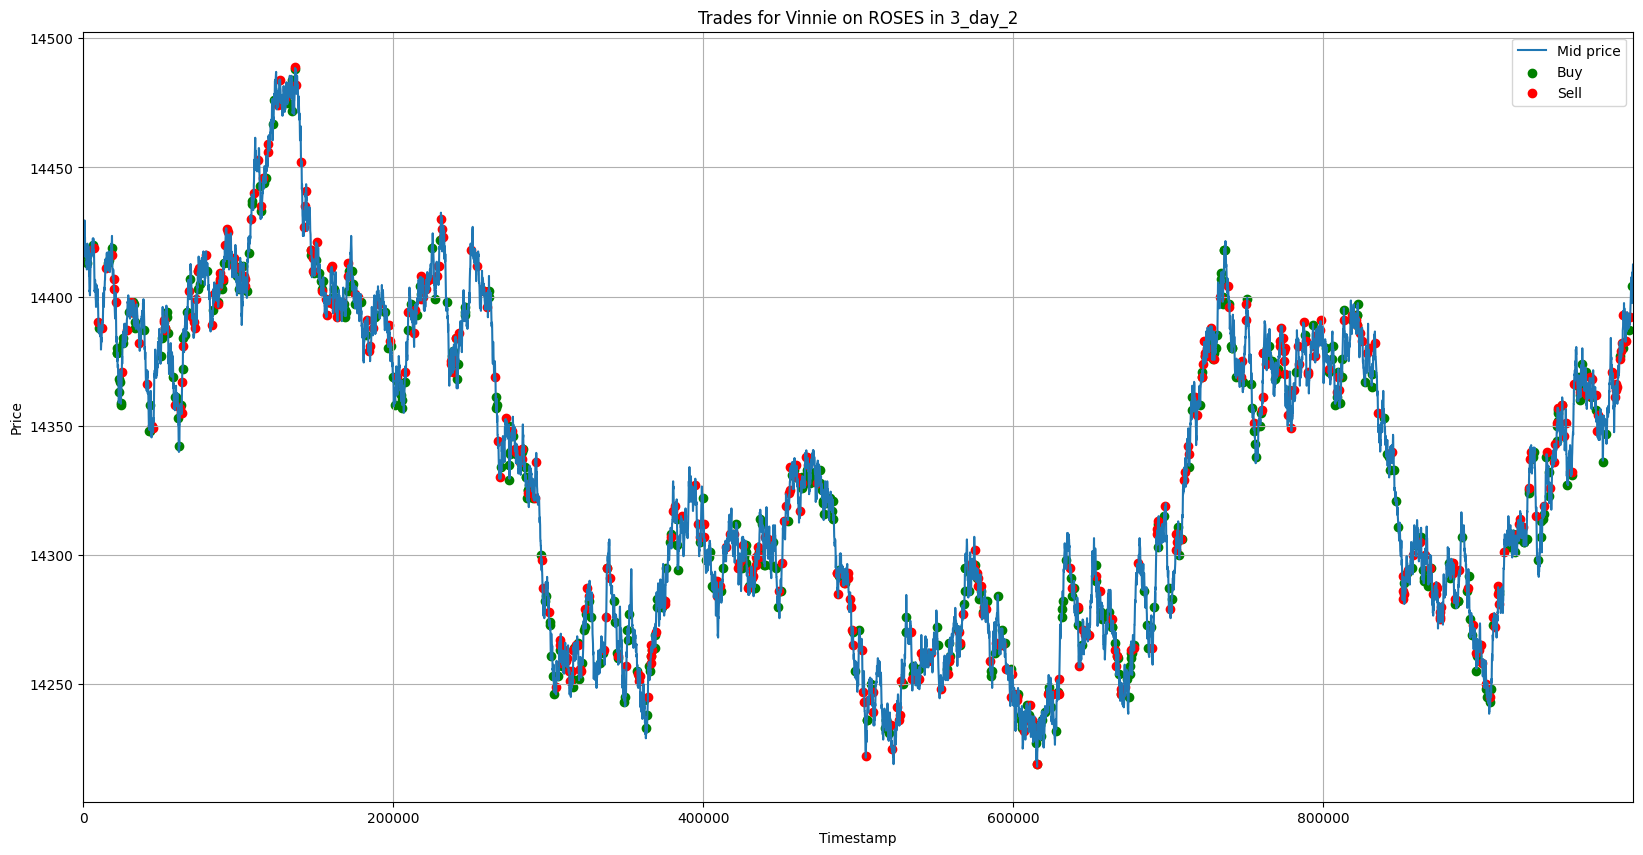

In [62]:
def plot_trades(path, trader, product):
    trades = get_data(path)
    prices = get_data(path, price_data=True)

    df = trades[(trades['buyer'] == trader) & (trades['symbol'] == product)]
    plt.figure(figsize=(20, 10))
    plt.plot(prices[prices['product'] == product]['timestamp'], prices[prices['product'] == product]['mid_price'], label='Mid price')
    plt.scatter(df['timestamp'], df['price'], label='Buy', color='green')
    df = trades[(trades['seller'] == trader) & (trades['symbol'] == product)]
    plt.scatter(df['timestamp'], df['price'], label='Sell', color='red')
    plt.legend()
    plt.grid()
    plt.ylabel('Price')
    plt.xlabel('Timestamp')
    plt.xlim(prices['timestamp'].min(), prices['timestamp'].max())
    plt.title(f'Trades for {trader} on {product} in {path}')
    plt.show()

plot_trades(paths[visualizing_path_index], visualizing_trader, visualizing_product)

Vinnie's gradient: 0.0005705693142742933, max position: 81.10329746800994, min position: -123.02372452299153.


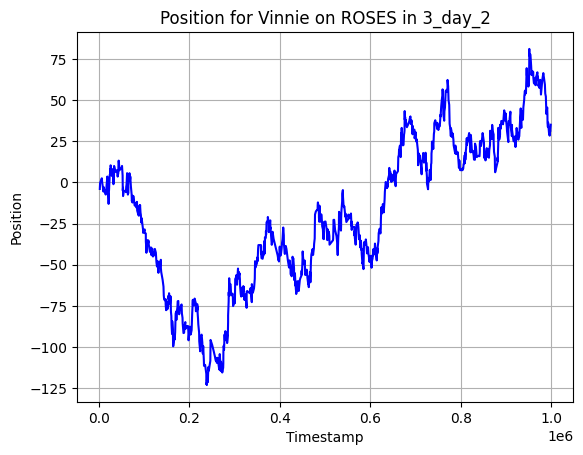

In [63]:
def calculate_position_per_timestamp(trades, trader, product):
    df = trades[((trades['buyer'] == trader) | (trades['seller'] == trader)) & (trades['symbol'] == product)]
    df.loc[df['seller'] == trader, 'quantity'] *= -1
    position = df['quantity'].cumsum()

    return position, df['timestamp']

visualizing_position, timestamps = calculate_position_per_timestamp(trades, visualizing_trader, visualizing_product)
vinnie_gradient = np.sum(visualizing_position * timestamps) / np.sum(timestamps**2)
visualizing_position -= timestamps * vinnie_gradient

print(f"Vinnie's gradient: {vinnie_gradient}, max position: {visualizing_position.max()}, min position: {visualizing_position.min()}.")

plt.plot(timestamps, visualizing_position, label='Position', color='blue')
plt.grid()
plt.ylabel('Position')
plt.xlabel('Timestamp')
plt.title(f'Position for {visualizing_trader} on {visualizing_product} in {paths[visualizing_path_index]}')
plt.show()

In [67]:
chocolate_gradients = [0.0016240030577276366, 0.001230117791351519, 0.0016973232408195637]
print(f'Chocolate: {np.mean(chocolate_gradients)}.')

strawberries_gradients = [0.002867351115039017, 0.0030598716831578524, 0.0029811434758810484]
print(f'Strawberries: {np.mean(strawberries_gradients)}.')

roses_gradients = [0.0006544743467379455, 0.0006896432979695391, 0.0005705693142742933]
print(f'Roses: {np.mean(roses_gradients)}.')

Chocolate: 0.0015171480299662398.
Strawberries: 0.0029694554246926393.
Roses: 0.0006382289863272592.


In [65]:
# path_indices = [0,1,2]
# regression_product = 'STARFRUIT'
# regression_traders = ['Rhianna', 'Valentina', 'Remy', 'Adam', 'Vinnie', 'Vladimir', 'Ruby', 'Amelia']

# regression_df = None
# for path_index in path_indices:
#     trades = get_data(paths[path_index])
#     prices = get_data(paths[path_index], price_data=True)
#     table = pd.DataFrame({'timestamp': prices['timestamp'].unique(), 'mid_price': prices[prices['product'] == regression_product]['mid_price'].pct_change()})
#     for trader in regression_traders:
#         position, timestamps = calculate_position_per_timestamp(trades, trader, regression_product)
#         table = pd.merge(table, pd.DataFrame({f'{trader}_position': position, 'timestamp': timestamps}), on='timestamp', how='left')
#     if regression_df is None:
#         regression_df = table
#     else:
#         regression_df = pd.concat([regression_df, table])

# columns_to_shift = [col for col in regression_df.columns if col not in ['timestamp', 'mid_price']]
# regression_df[columns_to_shift] = regression_df[columns_to_shift].shift(1)
# regression_df['mid_price'] = regression_df['mid_price'].shift(-1)
# regression_df.loc[0, columns_to_shift] = 0
# regression_df[columns_to_shift] = regression_df[columns_to_shift].ffill()

# regression_df = regression_df.dropna()
# regression_df.tail(10)


In [66]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error

# X = regression_df[columns_to_shift + ['timestamp']]
# y = regression_df['mid_price']

# model = LinearRegression()
# model.fit(X, y)
# predictions = model.predict(X)
# print(f'mean error: {np.mean(abs(y - predictions))}')
# print(f'mean movement: {np.mean(abs(y))}')
# print(model.coef_)